# Experiments

In this notebook is implemented the three experiments described in the paper.

## Header

Libraries and additional programs

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import random
from scipy.stats.stats import pearsonr

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]

pathh = '../Data/' 
exp_file = '../Data/ExperimentalResults.xlsx'   

## Initializing memory and encoding dataset in HD space

In [57]:
%run EncodingDataset.ipynb
Init_mem()

End of memory initialization
Begining to encode dataset...
End of encoding


## Experiment 1

Given a concept it retrieves the "num_concepts" most similar concepts to it (for each different method). A comparison between methods is done by counting the number of coincidences between lists of concepts.

(This experiment takes a while...)

In [58]:
# List of all concepts in dataset
Concepts = get_concepts_list() 

# Test concepts
sample_size = 10
#Test_Concepts = random.sample(Concepts, sample_size)
Test_Concepts =  ['spoon'] #, 'airplane', chair']
#print Test_Concepts

num_concepts = 11
coincidence = []

for test_concept in Test_Concepts:
    print "\n\nConcept: ", test_concept
    # Asking closest concept of another concept's definition...
    HDC_sim = HDvector.getLabelSP(Dict[test_concept].getPointer())[:num_concepts]
    HDC_sim = NormalizeHammDist(HDC_sim)
    print "HDC_sim: ", HDC_sim
    
    DatSet_sim = ClosestConcepts(test_concept, num_concepts)
    print "DatSet_sim: ", DatSet_sim

    concept = wn.synset( get_synset(test_concept) )
    # Path similarity
    LC_sim = apply_sim_metric(wn.lch_similarity, num_concepts, concept ) 
    print "LC_sim: ", LC_sim
    WUP_sim = apply_sim_metric(wn.wup_similarity, num_concepts, concept )
    print "WUP_sim: ", WUP_sim
    
    # Information Content
    Res_sim = apply_sim_metric(wn.res_similarity, num_concepts, concept, brown_ic)
    print "Res_sim: ", Res_sim
    JC_sim = apply_sim_metric(wn.jcn_similarity, num_concepts, concept, brown_ic)
    print "JC_sim: ", JC_sim
    
    # Comparing lists agains HDC_sim for counting coincidence.
    # Creating name sets
    HDC_names = set([x[0] for x in HDC_sim])
    DatSet_names = set([x[0] for x in DatSet_sim])
    LC_names = set([x[0] for x in LC_sim])
    WUP_names = set([x[0] for x in WUP_sim])
    Res_names = set([x[0] for x in Res_sim])
    JC_names = set([x[0] for x in JC_sim])
    
    coincidence = coincidence + [[len(HDC_names.intersection(DatSet_names)), 
                                 len(HDC_names.intersection(LC_names)), 
                                 len(HDC_names.intersection(WUP_names)),    
                                 len(HDC_names.intersection(Res_names)), 
                                 len(HDC_names.intersection(JC_names))]]
    print coincidence

coincidence = np.array(coincidence)

# Measuring average against each method.
print "Average: ", np.mean(coincidence, axis = 0)



Concept:  spoon
HDC_sim:  [['spoon', 1.0], ['ladle', 0.662], ['spatula', 0.628], ['fork', 0.623], ['colander', 0.617], ['tongs', 0.601], ['pot', 0.59], ['racquet', 0.589], ['grater', 0.588], ['strainer', 0.588], ['bucket', 0.587]]
DatSet_sim:  [['spoon', 1.0], ['fork', 0.546], ['ladle', 0.411], ['spatula', 0.395], ['tongs', 0.35], ['colander', 0.336], ['bowl', 0.292], ['strainer', 0.282], ['dish', 0.282], ['peg', 0.28], ['grater', 0.259]]
LC_sim:  [['spoon', 3.638], ['bag', 2.539], ['basket', 2.539], ['bin_(waste)', 2.539], ['box', 2.539], ['cup', 2.539], ['dish', 2.539], ['envelope', 2.539], ['fork', 2.539], ['thimble', 2.539], ['ashtray', 2.251]]
WUP_sim:  [['fork', 0.9], ['spoon', 0.9], ['bag', 0.875], ['basket', 0.875], ['bin_(waste)', 0.875], ['box', 0.875], ['envelope', 0.875], ['thimble', 0.875], ['ashtray', 0.824], ['barrel', 0.824], ['bathtub', 0.824]]
Res_sim:  [['spoon', 11.208], ['fork', 10.574], ['cup', 7.49], ['dish', 7.49], ['plate', 7.49], ['saucer', 7.49], ['ambulanc

## Experiment 2

### a) Human-judged similarity

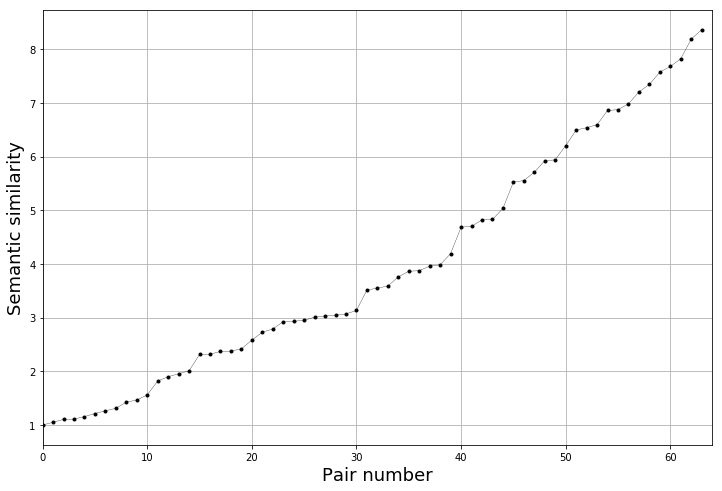

In [59]:
def ListofPairs (number):
    "It obtains the list of concept pairs rated by Humans"
    df = pd.read_excel(exp_file)
    if number > 0:
        string = 'Q' + str(number)    
    else:
        string = 'average'
    # 1) List of concepts
    ordered = df.sort_values(by=string)
    c1 = map(str, list( ordered['concept 1'] ))
    c2 = map(str, list( ordered['concept 2'] ))
    L1 = map(list, zip(c1,c2))

    # 2) Human similarity and stdev
    ordered = df.sort_values(by=string)
    L2 = list(ordered[string])
    L3 = list(ordered['stdev'])
    return L1, L2, L3

PConcepts, Hum_Sim, stdev = ListofPairs(0)

x = np.array(range(64))
stdev = np.array(map(lambda x: x*0.25, stdev))

plt.rcParams["figure.figsize"] = [12,8]

#plt.plot(Hum_Sim, fmt="k-")
plt.plot(Hum_Sim, color='k', linestyle='-', marker='.', markersize=6, linewidth=.3 )  


plt.xlim((0,64))
plt.xlabel('Pair number', fontsize=18)
plt.ylabel('Semantic similarity', fontsize=18)
plt.grid(True)
plt.savefig('HumSim.png', dpi=300)


### b) Measuring similarity

In this cell we measure the similarity of each pair of concepts with each similarity measure.

In [60]:
# Create dictionary of distances for each method
Dict_HD = {}; Dict_McRae = {}; Dict_wup = {}; Dict_lch = {}; Dict_res = {}; Dict_jcn = {}

# Loop over all pairs of concepts
key = 0
print "Starting"
for pair in PConcepts:
    print key,
    Dict_HD[key] = 1. - HDvector.dist(Dict[pair[0]].getPointer(), Dict[pair[1]].getPointer()) / float(N)
    Dict_McRae[key] = McRae_simi(pair)
    Dict_wup[key] = similarity_fun(wn.wup_similarity, pair)
    Dict_lch[key] = similarity_fun(wn.lch_similarity, pair)
    Dict_res[key] = similarity_fun(wn.res_similarity, pair, brown_ic)
    Dict_jcn[key] = similarity_fun(wn.jcn_similarity, pair, brown_ic)
    key += 1
print "End"

Starting
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 End


### c) Computing correlations

In [61]:
# 1) Obtain "human list", it can be the average responses or an specific one
Hum_sim =  ListofPairs(1) #or Q + #0-30
    
# 2) Obtain list of ordered concepts (keys)
keys = map(lambda x: PConcepts.index(x), Hum_sim[0])
    
# 3) Create a list of distances according to each metric by consulting the appropiate dictionary
HD_sim = [Dict_HD[x] for x in keys]
McRae_sim = [Dict_McRae[x] for x in keys]
wup_sim = [Dict_wup[x] for x in keys]
lch_sim = [Dict_lch[x] for x in keys]
res_sim = [Dict_res[x] for x in keys]
jcn_sim = [Dict_jcn[x] for x in keys]

# 4) Calculate correlations
correlations = [['HDC', pearsonr(Hum_sim[1], HD_sim)[0]], ['McRae', pearsonr(Hum_sim[1], McRae_sim)[0]],
                ['wup', pearsonr(Hum_sim[1], wup_sim)[0]], ['lch', pearsonr(Hum_sim[1], lch_sim)[0]],
                ['res', pearsonr(Hum_sim[1], res_sim)[0]], ['jcn', pearsonr(Hum_sim[1], jcn_sim)[0]]]

print correlations

[['HDC', 0.7132615705808644], ['McRae', 0.6579291336168837], ['wup', 0.5024104680950027], ['lch', 0.5237371792119226], ['res', 0.6407738417122745], ['jcn', 0.6132415801404195]]


## d) Plotting

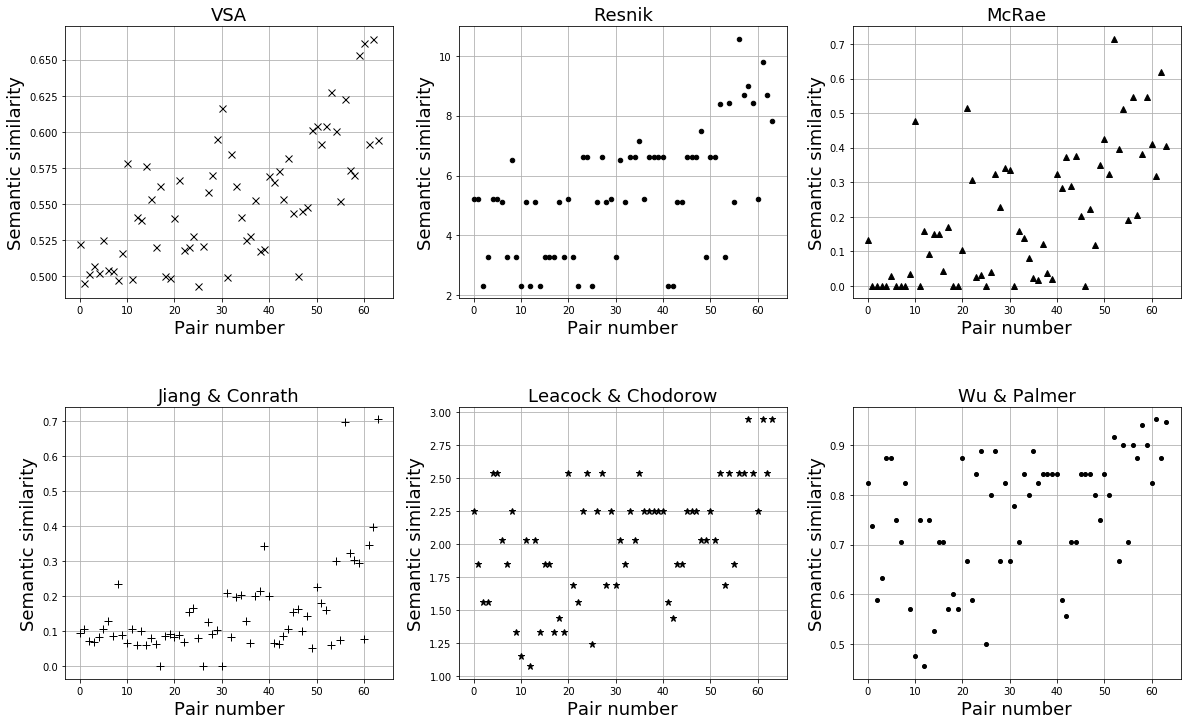

In [62]:
# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18

plt.subplots_adjust(hspace=0.4)
plt.subplot(231)
plt.plot(HD_sim, color='k', linestyle='None', marker='x', markersize=7, linewidth=1 )  

plt.title('VSA', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(232)
plt.plot(res_sim, color='k', linestyle='None', marker='.', markersize=9, linewidth=1 )  
plt.title('Resnik', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(233)
plt.plot(McRae_sim, color='k', linestyle='None', marker='^', markersize=6, linewidth=1 )  
plt.title('McRae', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(234)
plt.plot(jcn_sim, color='k', linestyle='None', marker='+', markersize=8, linewidth=1 )  
plt.title('Jiang & Conrath', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(235)
plt.plot(lch_sim, color='k', linestyle='None', marker='*', markersize=7, linewidth=1 )  
plt.title('Leacock & Chodorow', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(236)
plt.plot(wup_sim, color='k', linestyle='None', marker='.', markersize=8, linewidth=1 )  
plt.title('Wu & Palmer', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)


plt.savefig('SubPlots.png') #, dpi=1000)

# More experiments

In this notebook we compare the similarity results from our model to the MEN and SimLex-999 datasets.

## MEN dataset
_The MEN dataset consists of 3,000 word pairs. These were obtained by crowdsourcing using Amazon Mechanical Turk. 
The collection can be used to train and/or test computer algorithms implementing semantic similarity and relatedness measures.
Link for more information: https://staff.fnwi.uva.nl/e.bruni/MEN_

First we find how many pairs are there for which both concepts appear in the McRae dataset. 

In [63]:
# The variable 'Concepts' (previously created) contains the complete list of concepts in the McRae dataset
# Getting the pairs of concepts from the MEN dataset in a single list
MEN_path = "../Data/MEN_dataset_natural_form_full"
MEN_file = open(MEN_path, "r")
MEN = MEN_file.readlines()
MEN = [str.split(x) for x in MEN]

print(len(MEN))
MENList = []
for row in MEN:
    if row[0] in Concepts and row[1] in Concepts:
        MENList.append([row[0], row[1], float(row[2])])

# Sorting list...
MENList = sorted(MENList, key = lambda x: x[2])
print MENList

3000
[['tomato', 'whale', 3.0], ['mirror', 'raspberry', 4.0], ['brick', 'rabbit', 5.0], ['frog', 'subway', 5.0], ['cow', 'table', 6.0], ['pyramid', 'swimsuit', 6.0], ['bread', 'chair', 7.0], ['pillow', 'stone', 7.0], ['airplane', 'guitar', 7.0], ['brick', 'dress', 7.0], ['bucket', 'duck', 8.0], ['cherry', 'lamb', 8.0], ['van', 'vine', 8.0], ['car', 'hawk', 10.0], ['barn', 'mug', 10.0], ['lamb', 'lantern', 12.0], ['owl', 'rocket', 12.0], ['pin', 'truck', 12.0], ['rope', 'train', 13.0], ['door', 'skyscraper', 14.0], ['book', 'building', 14.0], ['lantern', 'oak', 14.0], ['lion', 'pelican', 19.0], ['chicken', 'pepper', 20.0], ['skateboard', 'swimsuit', 20.0], ['key', 'stone', 21.0], ['cherry', 'vine', 22.0], ['pepper', 'strawberry', 24.0], ['barn', 'owl', 24.0], ['deer', 'elephant', 24.0], ['marble', 'wall', 26.0], ['brick', 'skyscraper', 26.0], ['frog', 'whale', 26.0], ['pepper', 'tomato', 27.0], ['giraffe', 'lion', 31.0], ['orange', 'raspberry', 31.0], ['bag', 'pillow', 31.0], ['shirt', 

## Using MEN as Benchmark

### Measuring similarity for MEN concepts

In [64]:
# Create list of distances for each method
HD_sim_MEN = []; McRae_sim_MEN = []; WUP_sim_MEN = []; LCH_sim_MEN = []; RES_sim_MEN = []; JCN_sim_MEN = []
# Loop over all pairs of concepts
i = 0
print "Starting..."
for pair in MENList:
    print i,
    HD_sim_MEN.append(1. - HDvector.dist(Dict[pair[0]].getPointer(), Dict[pair[1]].getPointer()) / float(N))
    McRae_sim_MEN.append( McRae_simi(pair[0:2]) )
    WUP_sim_MEN.append(similarity_fun(wn.wup_similarity, pair[0:2]))
    LCH_sim_MEN.append(similarity_fun(wn.lch_similarity, pair[0:2]))
    RES_sim_MEN.append(similarity_fun(wn.res_similarity, pair[0:2], brown_ic))
    JCN_sim_MEN.append(similarity_fun(wn.jcn_similarity, pair[0:2], brown_ic))
    i += 1
print "End"

Starting...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 End


## Plotting

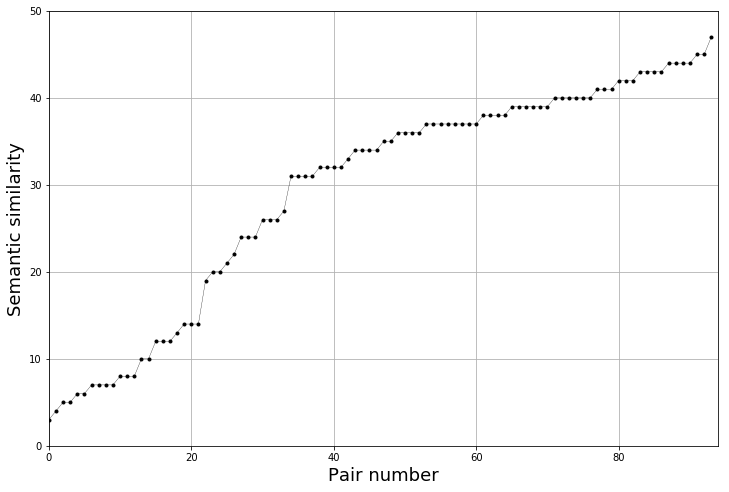

In [65]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot([x[2] for x in MENList], color='k', linestyle='-', marker='.', markersize=6, linewidth=.3 )  
plt.xlim((0,94))
plt.ylim((0,50))
plt.xlabel('Pair number', fontsize=18)
plt.ylabel('Semantic similarity', fontsize=18)
plt.grid(True)
plt.savefig('HumSim-MEN.png', dpi=300)

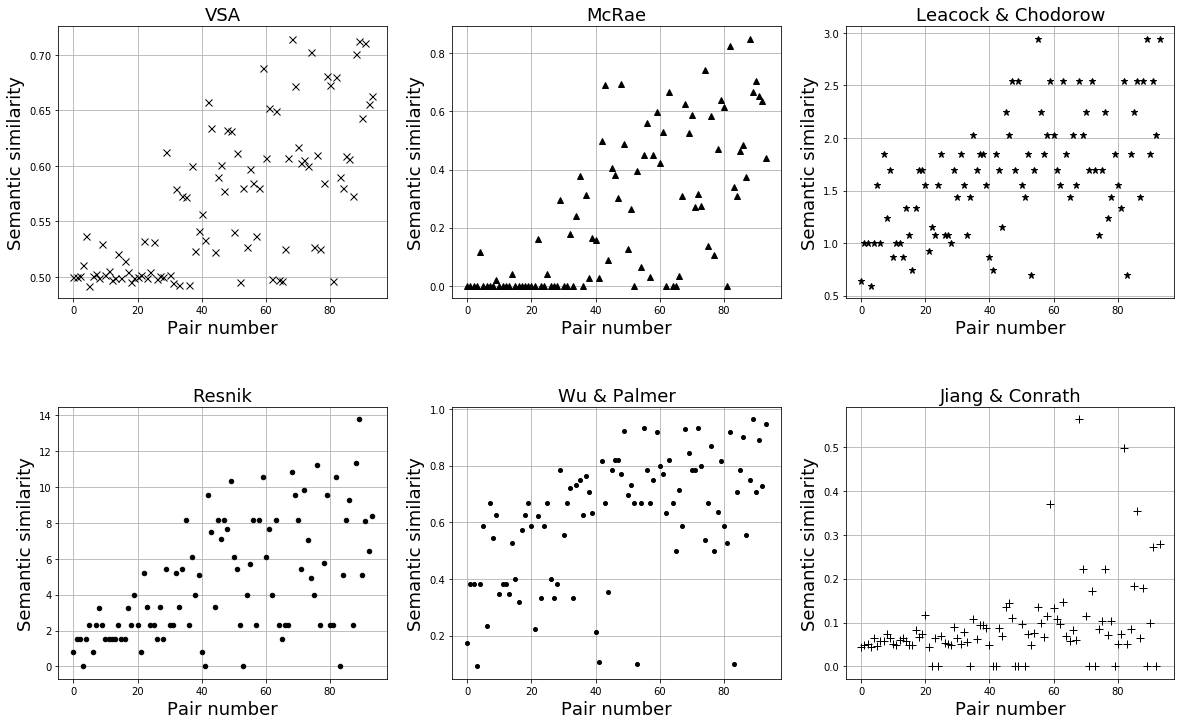

In [66]:
# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18
plt.subplots_adjust(hspace=0.4)

plt.subplot(231)
plt.plot(HD_sim_MEN, color='k', linestyle='None', marker='x', markersize=7, linewidth=1 )  
plt.title('VSA', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(232)
plt.plot(McRae_sim_MEN, color='k', linestyle='None', marker='^', markersize=6, linewidth=1 )  
plt.title('McRae', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(233)
plt.plot(LCH_sim_MEN, color='k', linestyle='None', marker='*', markersize=7, linewidth=1 )  
plt.title('Leacock & Chodorow', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(234)
plt.plot(RES_sim_MEN, color='k', linestyle='None', marker='.', markersize=9, linewidth=1 )  
plt.title('Resnik', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(235)
plt.plot(WUP_sim_MEN, color='k', linestyle='None', marker='.', markersize=8, linewidth=1 )  
plt.title('Wu & Palmer', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(236)
plt.plot(JCN_sim_MEN, color='k', linestyle='None', marker='+', markersize=8, linewidth=1 )  
plt.title('Jiang & Conrath', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.savefig('SubPlots-MEN.png') #, dpi=1000)

### Computing correlation

In [67]:
MENList_vals = [x[2] for x in MENList]

# SI FALTAN LAS GRAFICAS

correlations = [['HDC', pearsonr(MENList_vals, HD_sim_MEN)[0]], ['McRae', pearsonr(MENList_vals, McRae_sim_MEN)[0]],
                ['wup', pearsonr(MENList_vals, WUP_sim_MEN)[0]], ['lch', pearsonr(MENList_vals, LCH_sim_MEN)[0]],
                ['res', pearsonr(MENList_vals, RES_sim_MEN)[0]], ['jcn', pearsonr(MENList_vals, JCN_sim_MEN)[0]]]


correlations = sorted(correlations, key = lambda x : x[1], reverse = True)
print correlations

[['McRae', 0.6727384420807737], ['HDC', 0.6637104976416734], ['lch', 0.5844039704293345], ['res', 0.5775416063712382], ['wup', 0.5570825420221547], ['jcn', 0.3172684840266299]]


## SimLex-999 dataset

_SimLex-999 is a gold standard resource for the evaluation of models that learn the meaning of words and concepts. 
SimLex-999 provides a way of measuring how well models capture similarity, rather than relatedness or association. The scores in SimLex-999 therefore differ from other well-known evaluation datasets such as WordSim-353. Example:_

**coast - shore**   9.000 (SimLex-999 rating)    9.1 (WordSim-353 rating)

**clothes - closet**  1.96 (SimLex-999 rating)   9.1 (WordSim-353 rating)

_More information: https://fh295.github.io/simlex.html_

Just as with the previous dataset, first we find out how many pairs are there for which both concepts appear in the McRae dataset. 

In [68]:
SimLex_path = "../Data/SimLex-999.txt"
SimLex_file = open(SimLex_path, "r")

SimLex = SimLex_file.readlines()
SimLex = [str.split(x) for x in SimLex][1:]   # Removed first line (column's names)

#We are interested in the first to elements of each line (row)
SimLexList = []
for row in SimLex:
    if row[0] in Concepts and row[1] in Concepts and row[2] == 'N':
        SimLexList.append([row[0], row[1], float(row[3])])

print(len(SimLexList))

# Sorting list...
SimLexList = sorted(SimLexList, key = lambda x: x[2])
print SimLexList

44
[['car', 'hose', 0.87], ['car', 'bridge', 0.95], ['car', 'elevator', 1.03], ['mouse', 'cat', 1.12], ['box', 'cigar', 1.25], ['box', 'elevator', 1.32], ['house', 'carpet', 1.38], ['chicken', 'rice', 1.43], ['ball', 'basket', 1.67], ['dog', 'cat', 1.75], ['house', 'key', 1.9], ['bread', 'cheese', 1.95], ['door', 'cellar', 1.97], ['spoon', 'cup', 2.02], ['boat', 'anchor', 2.25], ['boat', 'car', 2.37], ['cat', 'rabbit', 2.37], ['dog', 'horse', 2.38], ['ball', 'cannon', 2.58], ['cow', 'goat', 2.93], ['horse', 'ox', 3.02], ['bed', 'bedroom', 3.4], ['bed', 'couch', 3.42], ['bed', 'chair', 3.5], ['gun', 'knife', 3.65], ['guitar', 'drum', 3.78], ['apple', 'lemon', 4.05], ['house', 'barn', 4.33], ['wall', 'brick', 4.68], ['calf', 'bull', 4.93], ['cup', 'jar', 5.13], ['plate', 'bowl', 5.23], ['door', 'gate', 5.25], ['gun', 'cannon', 5.68], ['house', 'apartment', 5.8], ['cabin', 'hut', 6.53], ['chair', 'bench', 6.67], ['sofa', 'chair', 6.67], ['cat', 'lion', 6.75], ['sweater', 'jacket', 7.15], 

### Measuring similarity for concepts in SimLex-999

In [69]:
# Create list of distances for each method
HD_SimLex = []; McRae_SimLex = []; WUP_SimLex = []; LCH_SimLex = []; RES_SimLex = []; JCN_SimLex = []

# Loop over all pairs of concepts
i = 0
print "Starting..."
for pair in SimLexList:
    print i,
    HD_SimLex.append(1. - HDvector.dist(Dict[pair[0]].getPointer(), Dict[pair[1]].getPointer()) / float(N))
    McRae_SimLex.append( McRae_simi(pair[0:2]) )
    WUP_SimLex.append(similarity_fun(wn.wup_similarity, pair[0:2]))
    LCH_SimLex.append(similarity_fun(wn.lch_similarity, pair[0:2]))
    RES_SimLex.append(similarity_fun(wn.res_similarity, pair[0:2], brown_ic))
    JCN_SimLex.append(similarity_fun(wn.jcn_similarity, pair[0:2], brown_ic))
    i += 1
print "End"

Starting...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 End


## Plotting SimLex-999

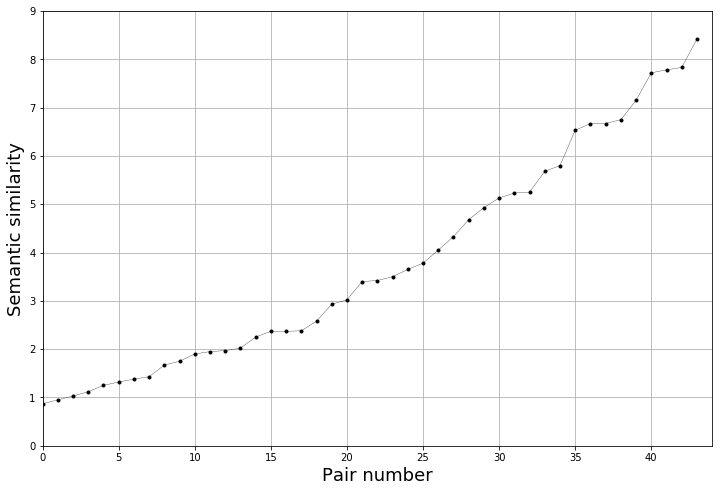

In [70]:
plt.rcParams["figure.figsize"] = [12,8]
plt.plot([x[2] for x in SimLexList], color='k', linestyle='-', marker='.', markersize=6, linewidth=.3 )  
plt.xlim((0,44))
plt.ylim((0,9))
plt.xlabel('Pair number', fontsize=18)
plt.ylabel('Semantic similarity', fontsize=18)
plt.grid(True)
plt.savefig('HumSim-SimLex.png', dpi=300)

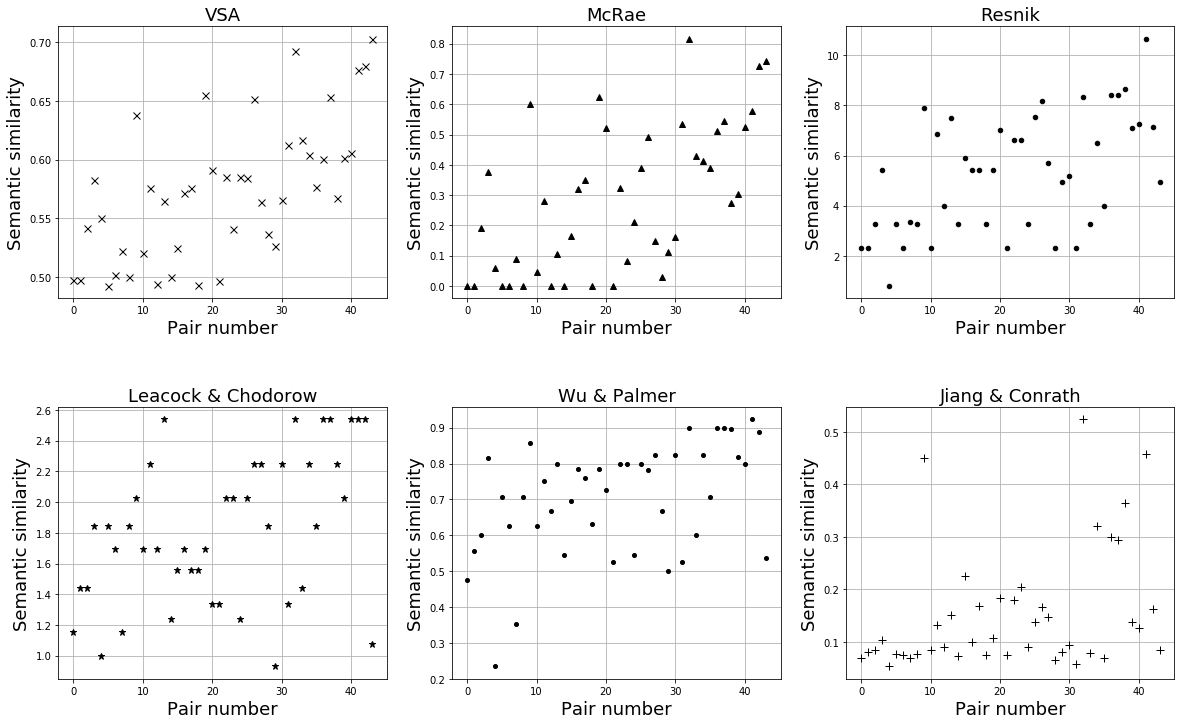

In [71]:
# Plotting
plt.rcParams["figure.figsize"] = [20,12]
f_size = 18
plt.subplots_adjust(hspace=0.4)

plt.subplot(231)
plt.plot(HD_SimLex, color='k', linestyle='None', marker='x', markersize=7, linewidth=1 )  
plt.title('VSA', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(232)
plt.plot(McRae_SimLex, color='k', linestyle='None', marker='^', markersize=6, linewidth=1 )  
plt.title('McRae', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)


plt.subplot(233)
plt.plot(RES_SimLex, color='k', linestyle='None', marker='.', markersize=9, linewidth=1 )  
plt.title('Resnik', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(234)
plt.plot(LCH_SimLex, color='k', linestyle='None', marker='*', markersize=7, linewidth=1 )  
plt.title('Leacock & Chodorow', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(235)
plt.plot(WUP_SimLex, color='k', linestyle='None', marker='.', markersize=8, linewidth=1 )  
plt.title('Wu & Palmer', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.subplot(236)
plt.plot(JCN_SimLex, color='k', linestyle='None', marker='+', markersize=8, linewidth=1 )  
plt.title('Jiang & Conrath', fontsize=f_size)
plt.xlabel('Pair number', fontsize=f_size)
plt.ylabel('Semantic similarity', fontsize=f_size)
plt.grid(True)

plt.savefig('SubPlots-SimLex.png') #, dpi=1000)

## Computing correlation

In [72]:
SimLex_vals = [float(x[2]) for x in SimLexList]

correlations = [['HDC', pearsonr(SimLex_vals, HD_SimLex)[0]], ['McRae', pearsonr(SimLex_vals, McRae_SimLex)[0]],
                ['wup', pearsonr(SimLex_vals, WUP_SimLex)[0]], ['lch', pearsonr(SimLex_vals, LCH_SimLex)[0]],
                ['res', pearsonr(SimLex_vals, RES_SimLex)[0]], ['jcn', pearsonr(SimLex_vals, JCN_SimLex)[0]]]

correlations = sorted(correlations, key = lambda x : x[1], reverse = True)

print correlations

[['HDC', 0.6629995407456739], ['McRae', 0.6249538446769186], ['res', 0.5148772163908228], ['lch', 0.43627661476892626], ['wup', 0.42406723211596103], ['jcn', 0.35782780233339617]]
